In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp

In [2]:
df = pd.read_excel("data.xlsx", sheet_name="Normal")[["Date&Time", "PM2.5"]]
df = df[1:] #Se elimina la primera fila
df = df[df["PM2.5"].apply(lambda x: type(x) == float)] #Filtro para los datos.

gf = pd.read_csv("sens.csv")
gf["fecha_hora_med"] = pd.to_datetime(gf["fecha_hora_med"])

In [3]:
df["Date&Time"] = pd.to_datetime(df["Date&Time"])
df = df.set_index("Date&Time") #Set datetime Index. 

gf["fecha_hora_med"] = pd.to_datetime(gf["fecha_hora_med"])
gf = gf.set_index("fecha_hora_med")

gf = gf.drop("id_parametro", axis = 1).rename(columns = {"valor": "PM2.5"}) #Cambiar nombre de las columnas


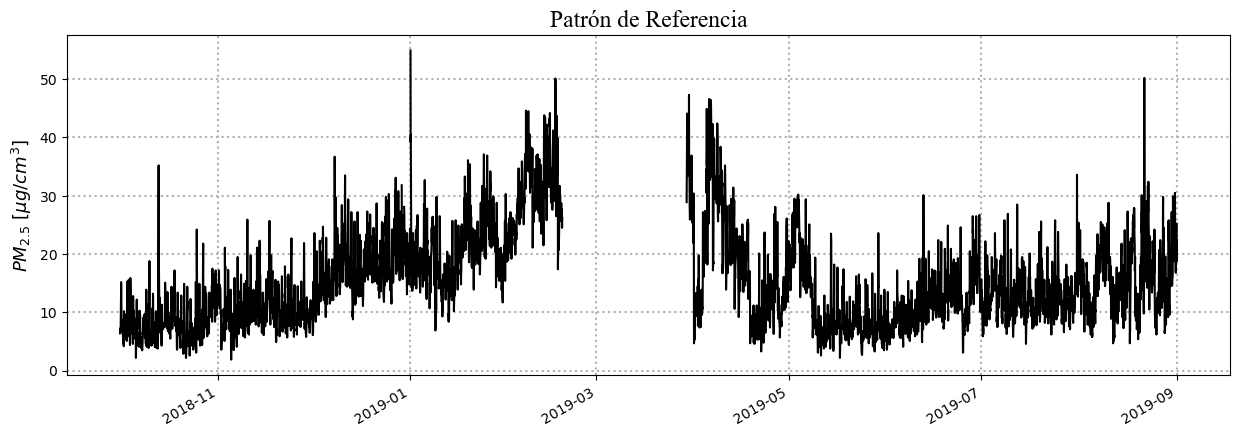

In [4]:
plt.figure(figsize = (15, 5))
plt.title("Patrón de Referencia", size = 17, fontname = "Times New Roman")

df["PM2.5"].plot(color = "k")
plt.xlabel(None)
plt.ylabel("$PM_{2.5}$ [$\mu g / cm^3$]", size = 13)
plt.grid(linestyle=':', linewidth=1.5)

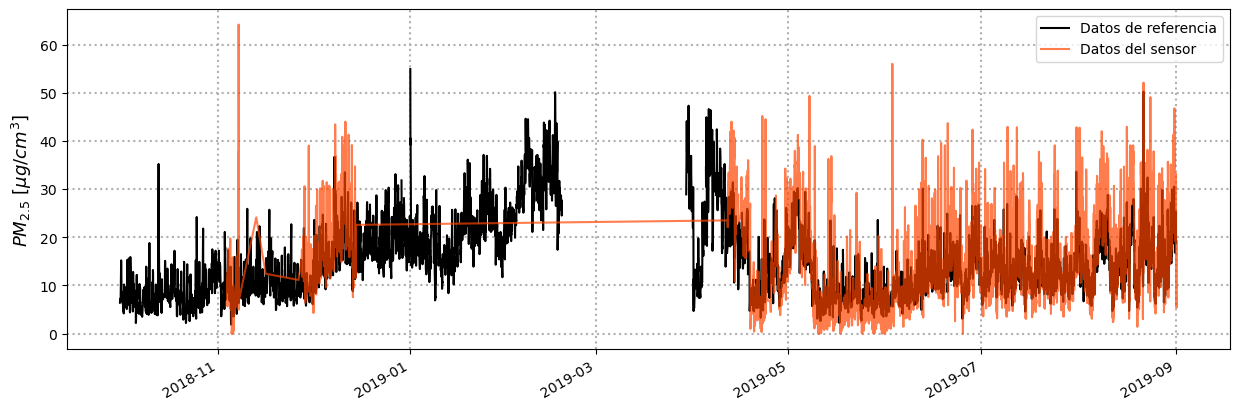

In [5]:
plt.figure(figsize = (15, 5))
#plt.title("Patrón de Referencia", size = 17, fontname = "Times New Roman")

df["PM2.5"].plot(color = "k", label = "Datos de referencia")

#plt.vlines(gf["PM2.5"].index.min(), 0, 50, linestyle = ":", linewidth = 3, color = "red")
#plt.vlines(gf["PM2.5"].index.max(), 0, 50, linestyle = ":", linewidth = 3, color = "red")
gf["PM2.5"].plot(color = "orangered", label = "Datos del sensor", alpha = 0.7)


plt.xlabel(None)
plt.ylabel("$PM_{2.5}$ [$\mu g / cm^3$]", size = 13)
plt.grid(linestyle=':', linewidth=1.5)
plt.legend()

### VENTANA: HORAS

In [6]:
ref = df.resample("H").mean() #Ventana Horas
sen = gf.resample("H").mean() 

sen.index = pd.to_datetime(sen.index).tz_convert('Etc/UCT') #Hacer que el formato coindicida
ref.index = pd.to_datetime(ref.index).tz_localize('Etc/UCT')

In [7]:
#recorte genereal.

data = pd.DataFrame({"data": ref["PM2.5"]["2019-03":], 
              "sen": sen["PM2.5"]["2019-03":]}, index = sen.index)

data = data.dropna(); data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2995 entries, 2019-04-11 17:00:00+00:00 to 2019-08-31 22:00:00+00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    2995 non-null   float64
 1   sen     2995 non-null   float64
dtypes: float64(2)
memory usage: 70.2 KB


In [8]:
def style(xlabel = None, ylabel = "$PM_{2.5}$ [$\mu g / cm^3$]", s = 13):
    
    plt.xlabel(xlabel, size = s)
    plt.ylabel(ylabel, size = s)
    plt.grid(linestyle=':', linewidth=1.5)

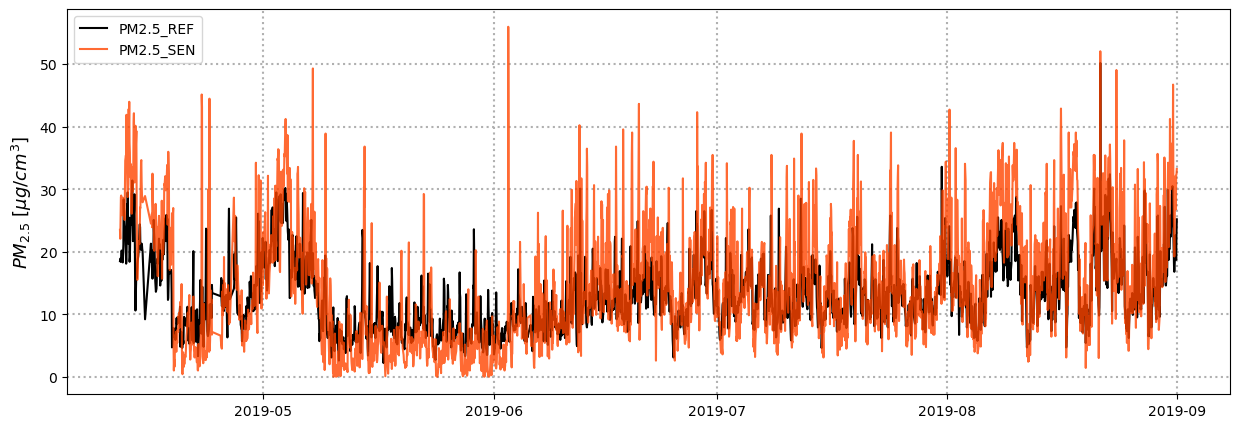

In [9]:
plt.figure(figsize = (15, 5))

plt.plot(data["data"], "k", label = "PM2.5_REF")
plt.plot(data["sen"], "orangered", alpha = 0.8, label = "PM2.5_SEN")


style()
plt.legend()

#Los datos del sensor y los de referencias tienen una correlación evidente pero no coinciden del todo, hace falta una calibracion.



In [10]:
units = "[$\mu g / cm^3$]"

$u = (A^TA)^-1y$

In [11]:
from scipy.optimize import curve_fit

In [12]:
def D(y, y_):
    return np.sqrt(((y - y_)**2).sum())

In [13]:
def linear(x, a, b): #Relación lineal
    return a + b*x

In [14]:
def error(y, y_):
    return D(y, y_) / len(y)

In [15]:
def fit(func,xdata,ydata, 
            r = 2, pop = False, imp = True):
    
    popt, pcov = curve_fit(func, xdata, ydata)
    
    #Error
    E = error(ydata, func(xdata, *popt))
    
        
    x = np.linspace(xdata.min(),xdata.max(),100)    
    #Visualización de coeficientes.
    popt, pcov = np.around(popt,r), np.around(np.sqrt(np.diag(pcov)),r)
    
    if imp:
        print("Coeficients are : {}".format(popt))
        print("Sigma_Coeficients are : {}".format(pcov))
        print("Error on fit is ={} %".format(round(E * 100, r )))
    
    #visualización de error.
    
    
    if pop:
        return popt
    
    return x, func(x, *popt)

In [16]:
pd.DataFrame({"x": data["sen"], "y": data["data"]}).to_csv("datos.csv",index = False)

Coeficients are : [6.9  0.41]
Sigma_Coeficients are : [0.14 0.01]
Error on fit is =7.44 %
Coeficients are : [6.9  0.41]
Sigma_Coeficients are : [0.14 0.01]
Error on fit is =7.44 %


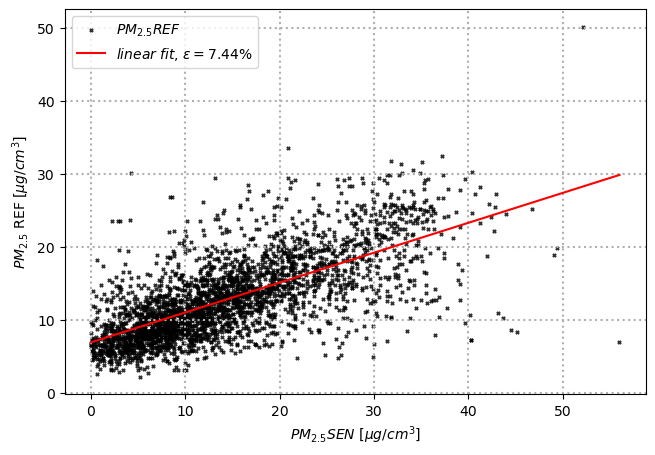

In [17]:
#Una visualización de la relacion entre los datos del sensor y los de referencia. 
plt.figure(figsize = (7.5, 5))

plt.scatter(data["sen"], data["data"], s = 5, marker = "x", color = "k", alpha = 0.8, label = "$PM_{2.5} REF$")
plt.plot(*fit(linear, data["sen"], data["data"]), "r", label = "$linear$ $fit$, $\epsilon = 7.44$%")

#plt.axis("scaled")
style("$PM_{2.5} SEN$ " + units, "$PM_{2.5}$ REF " + units, s = 10)

u_l = fit(linear, data["sen"], data["data"], pop = True)
plt.legend()


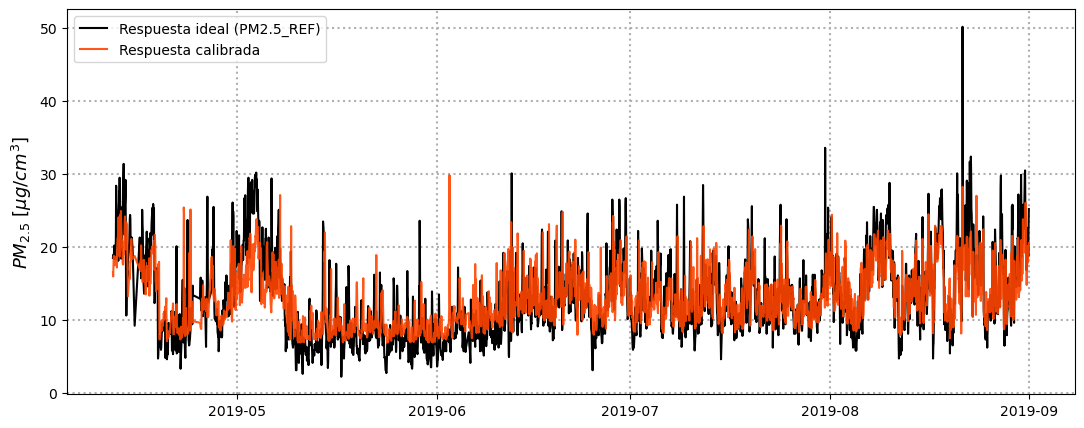

In [18]:
plt.figure(figsize = (13, 5))

plt.plot(data["data"], "k", label = "Respuesta ideal (PM2.5_REF)") #Datos de referencia
plt.plot(data.index, linear(data["sen"], *u_l), "orangered", alpha = 0.9, label = "Respuesta calibrada")


style()
plt.legend()

In [19]:
error(data["data"],linear(data["sen"], *u_l)) * 100

7.444329335189287

## Con media movil

C:\Users\jhona\AppData\Local\Temp\ipykernel_9128\4247822665.py:5: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  plt.plot(df["PM2.5"][smot.index[0]:], alpha = 0.7, label = "Original data")


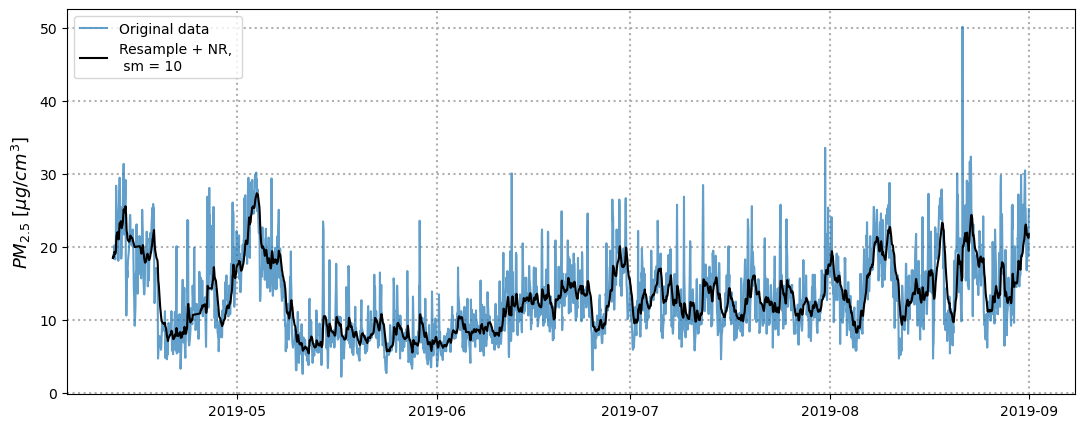

In [20]:
sm = 10
plt.figure(figsize = (13, 5))

smot = data.ewm(com=sm, adjust=True).mean()
plt.plot(df["PM2.5"][smot.index[0]:], alpha = 0.7, label = "Original data")
plt.plot(smot["data"], "k", label = "Resample + NR, \n sm = {}".format(sm))

style()
plt.legend(loc = "upper left")

In [21]:
days = (data.index[-1] - data.index[0]); days #Datos tomados corersponden a un analisis de 142 días

Timedelta('142 days 05:00:00')

In [22]:
pd.Timedelta("20d")

Timedelta('20 days 00:00:00')

In [23]:
#Define training interval.
m = 2 # Particion de los datos. 
train = smot[: smot.index[0] + days/m] #Modelo lienal a partir de un tercio de los datos. 
model = fit(linear, train["sen"], train["data"])
u_ls = fit(linear, train["sen"], train["data"], pop = True)

def calibration(xdata, coef = u_ls):
    return linear(xdata, *coef)


Coeficients are : [4.43 0.59]
Sigma_Coeficients are : [0.08 0.01]
Error on fit is =4.42 %
Coeficients are : [4.43 0.59]
Sigma_Coeficients are : [0.08 0.01]
Error on fit is =4.42 %


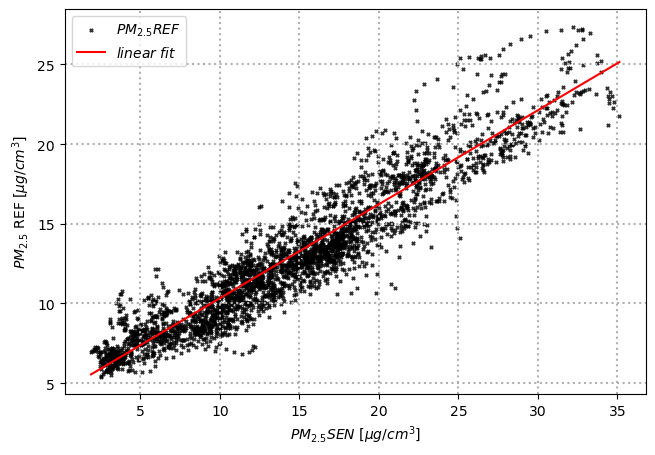

In [24]:
plt.figure(figsize = (7.5, 5))

plt.scatter(smot["sen"], smot["data"], s = 5, marker = "x", color = "k", alpha = 0.8, label = "$PM_{2.5} REF$")
plt.plot(*model, "r", label = "$linear$ $fit$")

#plt.axis("scaled")
style("$PM_{2.5} SEN$ " + units, "$PM_{2.5}$ REF " + units, s = 10)

plt.legend()


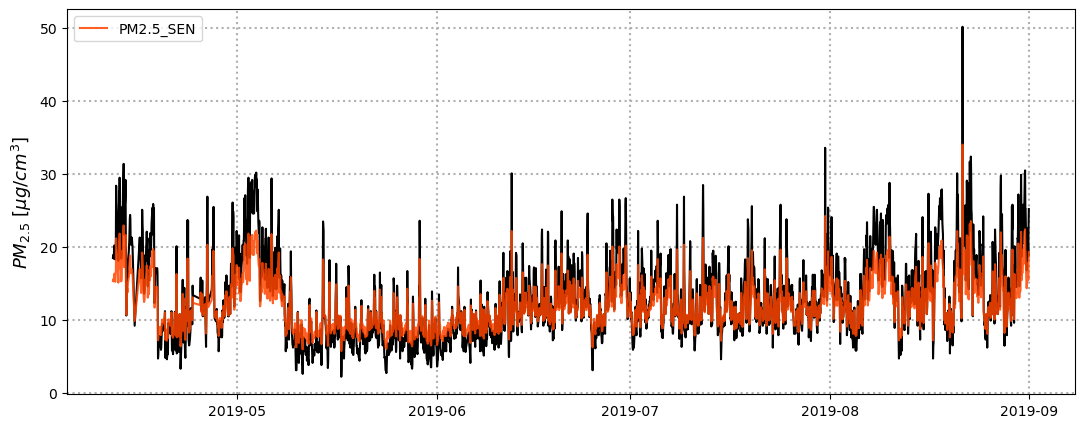

In [25]:
plt.figure(figsize = (13, 5))


plt.plot(data["data"], "k", alpha = 1)
#plt.plot(smot["data"], "k", label = "PM2.5_REF")
plt.plot(data.index, calibration(data["data"]), "orangered", alpha = 0.85, label = "PM2.5_SEN")


style()
plt.legend()

In [26]:
error(data["data"], calibration(data["data"])) * 100

4.5105047334242565

## Main function.

In [27]:
 def main(sm = 10, m = 1):
        
    plt.figure(figsize = (13, 5))

    smot = data.ewm(com=sm, adjust=True).mean()
    days = (data.index[-1] - data.index[0])
    
    #m = 2; # Particion de los datos. 
    train = smot[: smot.index[0] + days/m] #Modelo lineal a partir de un tercio de los datos. 
    model = fit(linear, train["sen"], train["data"], imp = False) 
    u_ls = fit(linear, train["sen"], train["data"], pop = True, imp = False)
    
    E = error(data["data"], calibration(data["data"], u_ls)) * 100
    
    return E
    

In [28]:
arange = np.linspace(0, 50, 100)
final = np.array(list(map(lambda x: main(x, 3), arange)))

C:\Users\jhona\AppData\Local\Temp\ipykernel_9128\3806600812.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (13, 5))


<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

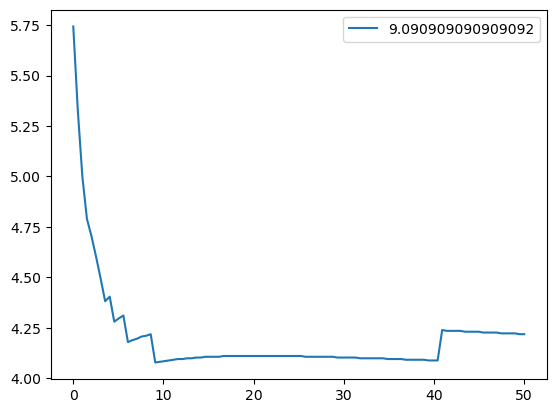

In [29]:
plt.plot(arange, final, label = arange[final.argmin()])
plt.legend()

In [30]:
def pedro(m):
    final = np.array(list(map(lambda x: main(x, m), arange)))
    return final.min()

In [31]:
m_array = list(map(pedro, np.linspace(1, 10, 100)))

C:\Users\jhona\AppData\Local\Temp\ipykernel_9128\3806600812.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (13, 5))


<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

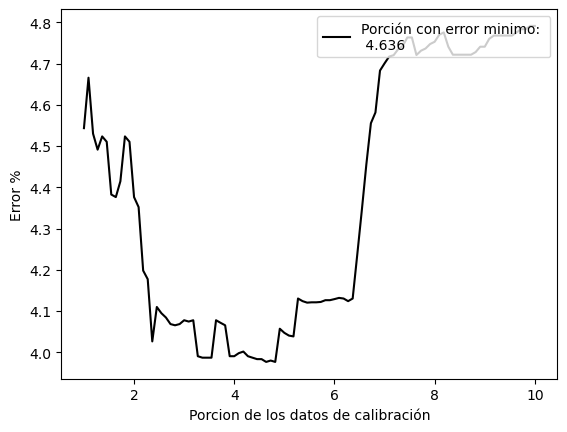

In [32]:
m_array = np.array(m_array)
plt.plot(np.linspace(1, 10, 100), m_array, "k", 
         label = "Porción con error minimo: \n {}".format(round(np.linspace(1, 10, 100)[m_array.argmin()], 3)))
plt.ylabel("Error %")
plt.xlabel("Porcion de los datos de calibración")

plt.legend(loc = 'upper right') #Aproximadamente 1/4 de los datos.

m_min = np.linspace(1, 10, 100)[m_array.argmin()]

In [33]:
arange = np.linspace(0, 50, 500)
final = np.array(list(map(lambda x: main(x, m_array.min()), arange)))

C:\Users\jhona\AppData\Local\Temp\ipykernel_9128\3806600812.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (13, 5))


<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

<Figure size 1300x500 with 0 Axes>

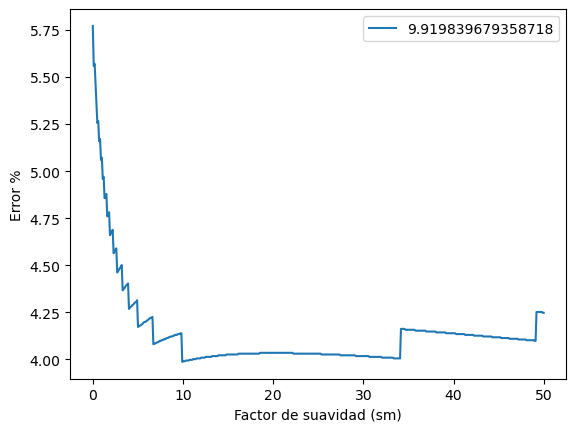

In [34]:
plt.plot(arange, final, label = arange[final.argmin()])
plt.ylabel("Error %")
plt.xlabel("Factor de suavidad (sm)")
plt.legend()

sm_min = arange[final.argmin()]

In [35]:
final.min() #Minimo error posible

3.987095537431667

In [36]:
 def main_plot(sm = 10, m = 1):
        
    plt.figure(figsize = (13, 5))

    smot = data.ewm(com=sm, adjust=True).mean()
    days = (data.index[-1] - data.index[0])
    
    #First Plot.
    plt.plot(df["PM2.5"][smot.index[0]:], alpha = 0.7, label = "Original data")
    plt.plot(smot["data"], "k", label = "Resample + NR, \n sm = {}".format(sm))

    style()
    plt.legend(loc = "upper left")
    
    
    
    #m = 2; # Particion de los datos. 
    train = smot[: smot.index[0] + days/m] #Modelo lineal a partir de un tercio de los datos. 
    model = fit(linear, train["sen"], train["data"], imp = False) 
    u_ls = fit(linear, train["sen"], train["data"], pop = True, imp = False)
    
    #Second Plot
    plt.figure(figsize = (7.5, 5))

    plt.scatter(smot["sen"], smot["data"], s = 5, marker = "x", color = "k", alpha = 0.8, label = "$PM_{2.5} REF$")
    plt.plot(*model, "r", label = "$linear$ $fit$")

    #plt.axis("scaled")
    style("$PM_{2.5} SEN$ " + units, "$PM_{2.5}$ REF " + units, s = 10)

    plt.legend()
    
    
    plt.figure(figsize = (13, 5))


    plt.plot(data["data"], "k", alpha = 1)
    #plt.plot(smot["data"], "k", label = "PM2.5_REF")
    plt.plot(data.index, calibration(data["data"]), "orangered", alpha = 0.85, label = "PM2.5_SEN")


    style()
    plt.legend()
    
    E = error(data["data"], calibration(data["data"], u_ls)) * 100
    
    return E
    

C:\Users\jhona\AppData\Local\Temp\ipykernel_9128\3490659078.py:9: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  plt.plot(df["PM2.5"][smot.index[0]:], alpha = 0.7, label = "Original data")


4.118010254201792

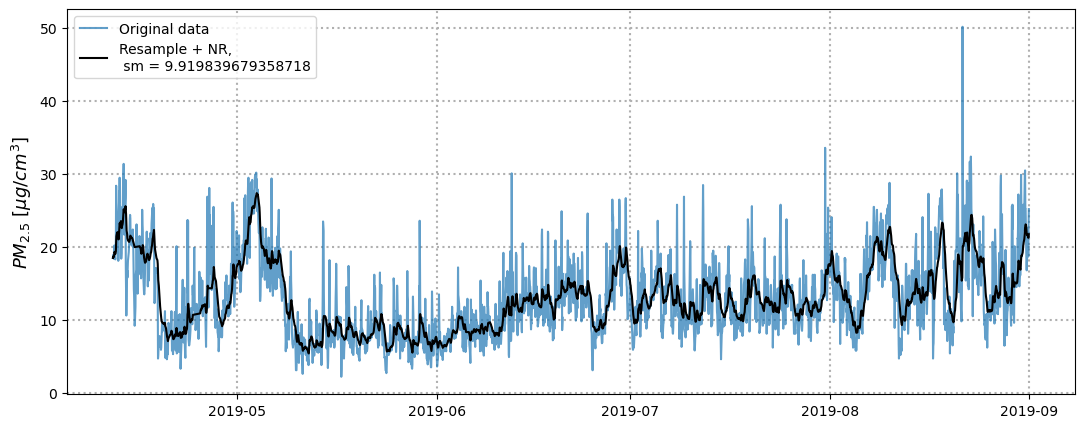

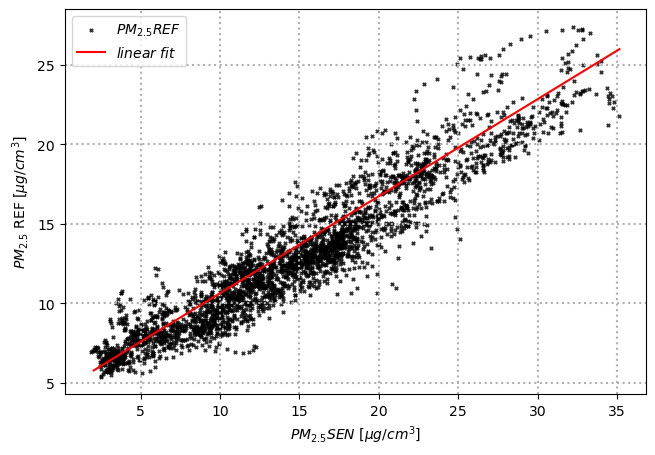

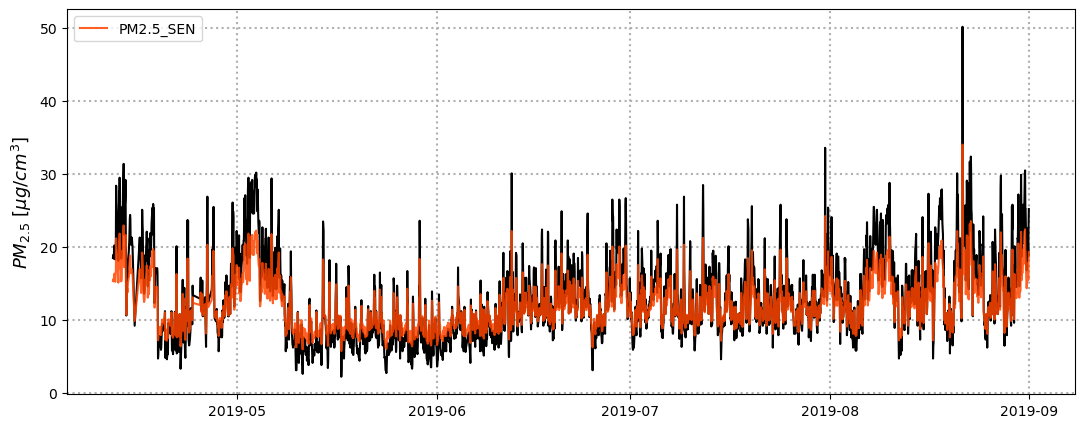

In [37]:
main_plot(sm_min, m_min)

In [40]:
error(data["data"], data["sen"]) * 100

12.929304982979028

In [41]:
u_l

array([6.9 , 0.41])